In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from datetime import datetime
from utils import BNN
import json
import openturns as ot
import seaborn as sns

import dask.dataframe as dd
import pandas as pd

In [2]:
file_name = "../Aircraft_01.h5"

# store = pd.HDFStore(file_name)
# store_keys = store.keys()
# with pd.HDFStore(f'{file_name[:-3]}_dask.h5', mode = "w") as h :
#     for i in range(len(store)) :
#         key = store_keys[i]
#         h.put(key, store[store_keys[i]], format = 'table')
ddf = dd.read_hdf(f'{file_name[:-3]}_dask.h5', '*')

In [3]:
ddf.partitions[0].columns

Index(['ALT [ft]', 'EGT_1 [deg C]', 'EGT_2 [deg C]', 'FMV_1 [mm]',
       'FMV_2 [mm]', 'HPTACC_1 [%]', 'HPTACC_2 [%]', 'M [Mach]',
       'N1_1 [% rpm]', 'N1_2 [% rpm]', 'N2_1 [% rpm]', 'N2_2 [% rpm]',
       'NAIV_1 [bool]', 'NAIV_2 [bool]', 'P0_1 [psia]', 'P0_2 [psia]',
       'PRV_1 [bool]', 'PRV_2 [bool]', 'PS3_1 [psia]', 'PS3_2 [psia]',
       'PT2_1 [mbar]', 'PT2_2 [mbar]', 'P_OIL_1 [psi]', 'P_OIL_2 [psi]',
       'Q_1 [lb/h]', 'Q_2 [lb/h]', 'T1_1 [deg C]', 'T1_2 [deg C]',
       'T2_1 [deg C]', 'T2_2 [deg C]', 'T3_1 [deg C]', 'T3_2 [deg C]',
       'T5_1 [deg C]', 'T5_2 [deg C]', 'TAT [deg C]', 'TBV_1 [%]', 'TBV_2 [%]',
       'TCASE_1 [deg C]', 'TCASE_2 [deg C]', 'TLA_1 [deg]', 'TLA_2 [deg]',
       'T_OIL_1 [deg C]', 'T_OIL_2 [deg C]', 'VBV_1 [mm]', 'VBV_2 [mm]',
       'VIB_AN1_1 [mils]', 'VIB_AN1_2 [mils]', 'VIB_AN2_1 [ips]',
       'VIB_AN2_2 [ips]', 'VIB_BN1_1 [mils]', 'VIB_BN1_2 [mils]',
       'VIB_BN2_1 [ips]', 'VIB_BN2_2 [ips]', 'VSV_1 [mm]', 'VSV_2 [mm]'],
      dtyp

$N_2 = c + \alpha N_1 + \beta T_1 + \gamma Alt + \theta M + \epsilon$

$X := \begin{pmatrix} 
1 & N_1^{1} & T_1^{1} & Alt^{1} & M^1 \\ 
\vdots  & \vdots &\vdots &\vdots & \vdots \\
1 & N_1^{N} & T_1^{N} & Alt^{N} & M^N \\ 
\end{pmatrix}$ et $a = \begin{pmatrix} c \\ \alpha \\ \beta \\ \gamma \\ \theta
\end{pmatrix}$

On a $N_2 = X a + \epsilon$ 

$\hat{a} = (X^T X)^{-1} X^T Y$

In [4]:
N2_1 = ddf.partitions[0]["N2_1 [% rpm]"].compute().values.reshape(-1,1)
N1_1 = ddf.partitions[0]["N1_1 [% rpm]"].compute().values.reshape(-1,1)
T1_1 = ddf.partitions[0]["T1_1 [deg C]"].compute().values.reshape(-1,1)
Alt = ddf.partitions[0]["ALT [ft]"].compute().values.reshape(-1,1)
M = ddf.partitions[0]["M [Mach]"].compute().values.reshape(-1,1)

In [5]:
X = np.concatenate((np.ones(N1_1.shape), N1_1, T1_1, Alt, M),1)
hatA = np.linalg.solve(np.matmul(X.transpose(), X), np.matmul(X.transpose(), N2_1))
hatN2_1 = np.matmul(X, hatA)

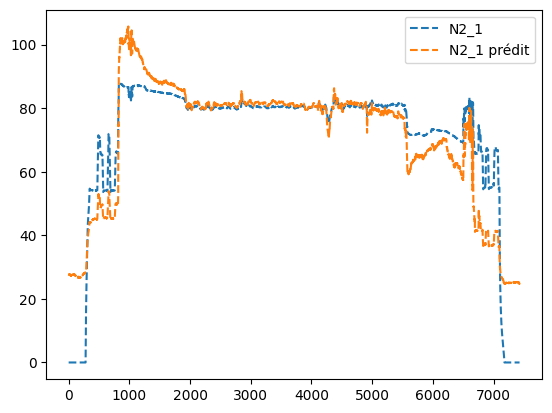

In [6]:
plt.figure()
plt.plot(N2_1, label = 'N2_1', linestyle = 'dashed')
plt.plot(hatN2_1, label = "N2_1 prédit", linestyle = 'dashed')
plt.legend()
plt.show()

Ici on voit qu'il y a une différence entre les deux graphiques, maintenant on va essaye avec une distribution sur les poids $a$.

In [7]:
# Convertion
XT = torch.Tensor(X[:,1:]).reshape(X[:,1:].shape)
N2_1T = torch.Tensor(N2_1).reshape(N2_1.shape)

In [47]:
# Hypperparamètres
N = 5000
lmax = 12
P0 = 0.1
epsilon = 1
sigma_0 = 0.01
ns = [4,1]

# Temperature initiale
Temp = 0.0001

# Distance qui va être utiliser pour évaluer
# la dissimilarité entre les prédictions y_hat et la réponse y
pdist = 2


# Ici on commence l'algorithm BNN-ABC-SS
# Notre modèle
myModel = BNN.FNN(ns)
myModelSize = BNN.modelSize(ns)

# Distribution a priori
# thetaPrior = ot.Normal(0, sigma_0)
thetas = torch.randn(myModelSize, N) * sigma_0 + torch.tensor(hatA[[1,2,3,4,0]], dtype = torch.float32)
# Fixe la variance de la distribution de proposition
sigma_j = sigma_0

# Feedforward
y_hats = torch.concat(
    tuple([myModel.update_weights(thetas[:, i]).forward(XT) for i in range(0, N)]), 1)

# Calcul la dissimilarité
rhos = (torch.cdist(y_hats.t(), N2_1T.t(), p=pdist) ** 2)/ myModelSize

#  
rhoMin = []
rhoMax = []

#
NP0 = int(N*P0)
invP0 = int(1/P0)

a, _ = torch.sort(rhos)
a 

tensor([[5.7547e+07],
        [1.8496e+07],
        [4.0029e+07],
        ...,
        [1.0221e+08],
        [5.5973e+08],
        [3.6738e+07]], grad_fn=<SortBackward0>)

In [48]:
for j in range(1, lmax + 1):

    # On trie les erreurs et on mets les poids dans
    # l'ordre croissant des érreurs qu'ils produisent
    rhos, indices = torch.sort(rhos, 0)

    rhoMin.append(str(np.float32(torch.min(rhos).detach())))
    rhoMax.append(str(np.float32(torch.max(rhos).detach())))

    thetas = thetas[:, indices.t()[0]]

    epsilon_j = rhos[NP0]

    # Ici on a un échantillion de taille NP0 et on veut
    # en créer N à partir de cette échantillion en fesant
    # (invPO - 1) pas
    thetasSeeds = thetas[:, :NP0]
    rhosSeeds = rhos[:NP0]

    # Réglage de sigma_j
    sigma_j = sigma_0 - 0.1 * lmax

    #
    thetasNew = thetasSeeds
    rhosNew = rhos[:NP0]

    for k in range(NP0):
        mu = thetasSeeds[:, k]

        for i in range(invP0 - 1):
            thetaStar = torch.randn(mu.shape) * sigma_j + mu
            y_hats = myModel.update_weights(thetaStar).forward(XT)
            rhoStar = (torch.cdist(y_hats.t(), N2_1T.t(), p=pdist) ** 2) / myModelSize

            if (rhoStar <= epsilon_j):
                thetasNew = torch.concatenate(
                    (thetasNew, thetaStar.reshape(-1, 1)), 1)
                rhosNew = torch.concatenate((rhosNew, rhoStar), 0)
                mu = thetaStar

            else:
                thetasNew = torch.concatenate(
                    (thetasNew, thetasSeeds[:, k].reshape(-1, 1)), 1)
                rhosNew = torch.concatenate(
                    (rhosNew, rhosSeeds[k].reshape(-1, 1)), 0)

    thetas = thetasNew
    rhos = rhosNew

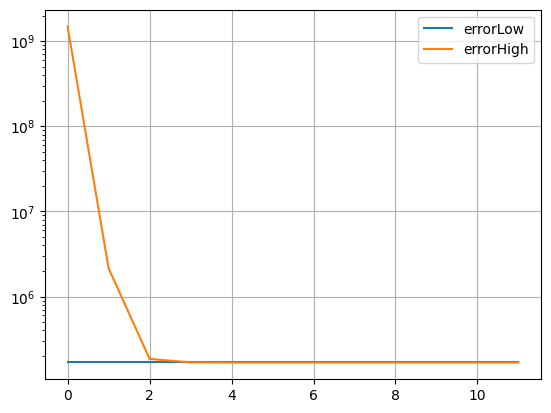

In [49]:
plt.figure()
plt.plot(np.float32(rhoMin), label = 'errorLow')
plt.plot(np.float32(rhoMax), label = 'errorHigh')
plt.yscale('log')
plt.legend()
plt.grid('on')
plt.show()

In [144]:
plt.clf()
plt.plot(N2_1, label = 'N2_1', linestyle = 'dashed')
plt.plot(hatN2_1, label = "N2_1 prédit", linestyle = 'dashed')
# plt.plot(q2_5, label = 'q2.5%', linestyle = 'dashed',color="#e8e8e8")
# plt.plot(q97_5, label = "q97.5%", linestyle = 'dashed',color="#e8e8e8")
# plt.plot(q25, label = 'q25%', linestyle = 'dashed', color="#bfbfbf")
# plt.plot(q75, label = "q75%", linestyle = 'dashed', color="#bfbfbf")
plt.plot(med, label = "mediane", linestyle = 'dashed', color="#8c0e11")
plt.legend()
plt.show()

In [145]:
rhoMin

['2523901.0',
 '823968.0',
 '797033.6',
 '285130.4',
 '260190.38',
 '239960.78',
 '239960.78',
 '239208.42',
 '236200.4',
 '236200.4',
 '236172.8',
 '235908.0']